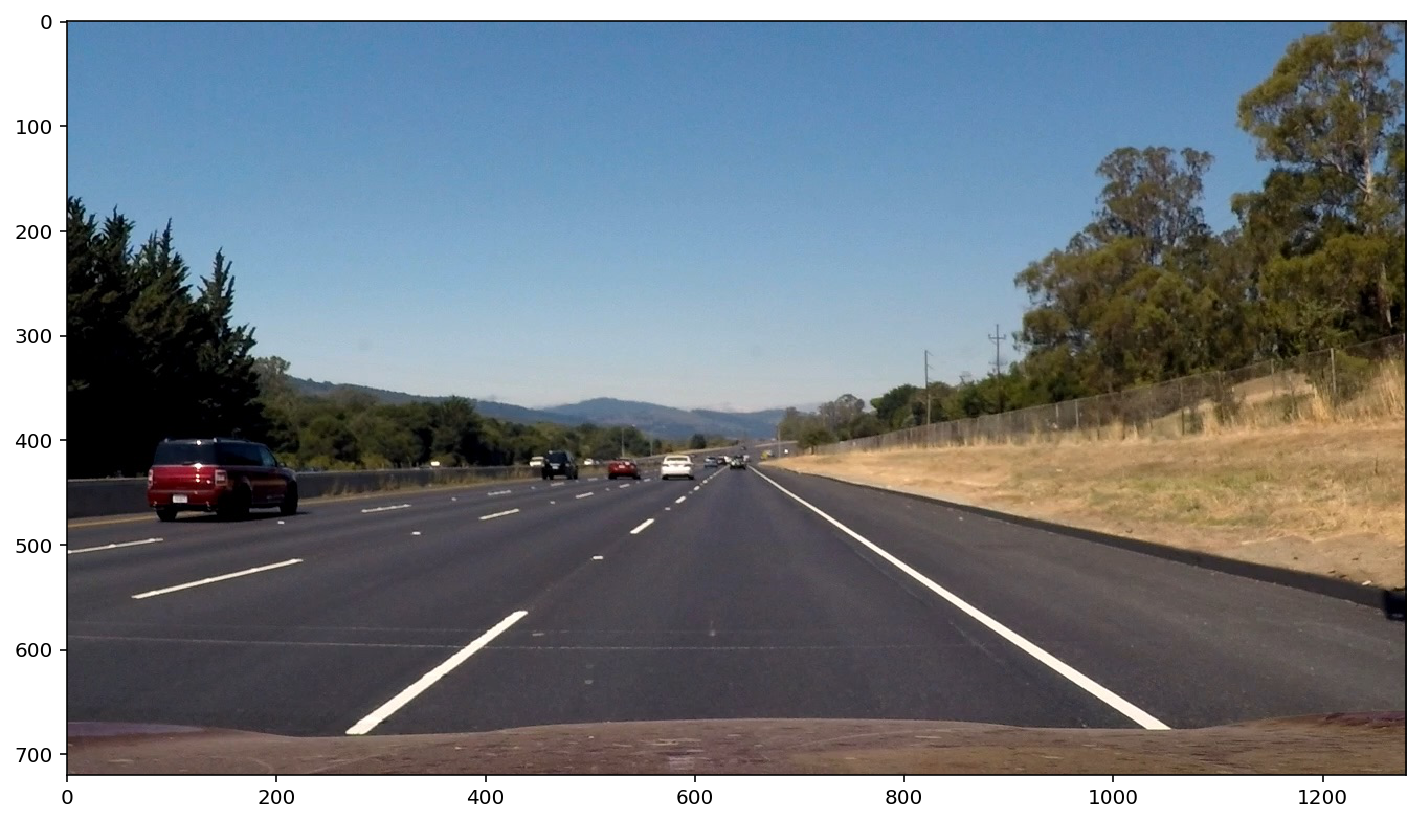

In [1]:
#Need to have more testing and test loading images.


import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def component():
  return random.randint(0,255)

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=2):
    # make a copy of the image
    draw_img = np.copy(img)
    
    for bbox in bboxes:
        (x1, y1), (x2, y2) = bbox
        cv2.rectangle(draw_img, (x1, y1), (x2, y2), (component(),component(),component()), thick)
    
    
    # draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes

image = mpimg.imread('test_images/straight_lines2.jpg')

plt.figure(figsize=(12,12))
plt.imshow(image)

In [204]:
from skimage.feature import hog

def convert_color(img,cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    
    return feature_image

def get_hog_vector(hog_features):
    return np.hstack((
            hog_features[0].ravel(), 
            hog_features[1].ravel(), 
            hog_features[2].ravel()))
        

def get_hog_features(
        img,
        cspace,
        orientations, 
        pix_per_cell, 
        cell_per_block):
    
    img = convert_color(img,cspace)
    
    img = img / 255
    
    results = []
    
    for channel in range(img.shape[2]):
        
        image = img[:,:,channel]
 
        features = hog(
            image, 
            orientations=orientations,
            pixels_per_cell=(pix_per_cell, pix_per_cell), 
            cells_per_block=(cell_per_block, cell_per_block), 
            visualise=False, 
            feature_vector=False,
            block_norm="L2-Hys",
            transform_sqrt = False)
        
        results.append(features)
    
    result = np.array(results)
    
    return result


def get_spatial_features(image, color_space, size=(32, 32)):
 
    img = convert_color(image,color_space)
    
    img / 255
    
    features = cv2.resize(img, size).ravel() 

    return features

 
def get_color_histogram_features(image, color_space, nbins=32, bins_range=(0, 256)):
    
    img = convert_color(image,color_space)
    
    img / 255
    
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

    return features


In [266]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import glob

def extract_features(files,get_features):
    
    features = []
        
    for file in files:
        
        image = mpimg.imread(file)
        
        features.append(get_features(image))
        
    return np.array(features)


def get_training_files(trainingset='largeset'):
    
    images = glob.glob('data/*{0}/*/*.*'.format(trainingset))
    
    cars = []
    notcars = []
    
    for image in images:
        if 'non-vehicles' in image:
            notcars.append(image)
        else:
            cars.append(image)

    return cars, notcars

 
    
def train(
        cspace,
        orientations,
        pix_per_cell,
        cell_per_block):
    
    
    def get_features(image,hog_features = []):
        
        #if len(hog_features) == 0:
        
        hog_features = get_hog_features(
                image,
                cspace = cspace,
                orientations = orientations,
                pix_per_cell = pix_per_cell,
                cell_per_block = cell_per_block)
            
        #spatial_features = get_spatial_features(image,cspace)
        #color_histogram_features = get_color_histogram_features(image,cspace)
        #
        #features = np.concatenate((
        #    get_hog_vector(hog_features),
        #    spatial_features.astype(np.float64),
        #    color_histogram_features.astype(np.float64)
        #    ))
        
            
        return get_hog_vector(hog_features)
            
         
    cars, notcars = get_training_files(trainingset='largeset')
      
    car_features = extract_features(
                            cars,
                            get_features)
    
    notcar_features = extract_features(
                            notcars,
                            get_features)
    
    y = np.hstack((np.ones(len(car_features)),np.zeros(len(notcar_features))))

    X = np.vstack((car_features, notcar_features)).astype(np.float64)
        
    X_scaler = StandardScaler().fit(X)

    scaled_X = X_scaler.transform(X)

    rand_state = np.random.randint(0, 100)
    
    
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, 
        y, 
        test_size=0.2, 
        random_state=rand_state)

    svc = LinearSVC()

    svc.fit(X_train, y_train) 
    
    print('Test Accuracy of SVC = ', svc.score(X_test, y_test))
    
    def predict(image,hog_features=[]):
    
        features = get_features(image,hog_features)

        scaled = X_scaler.transform(features.reshape(1,-1))
    
        return np.int(svc.predict(scaled)) == 1
    
    return predict
  
predict = train(
        cspace = 'YUV',
        orientations = 11,
        pix_per_cell = 16,
        cell_per_block = 2)


Test Accuracy of SVC =  0.971846846847


In [313]:
def prediction_test():
    
    cars, notcars = get_training_files(trainingset='largeset')
    
    index = random.randint(0,len(notcars))
    
    img = mpimg.imread(notcars[index])
    
    print(img)
    
    print(predict(img))
 #Need to random select images and show predictions   

In [314]:
prediction_test()

[[[ 0.14117648  0.18039216  0.15294118]
  [ 0.14901961  0.1882353   0.16470589]
  [ 0.15686275  0.20392157  0.18039216]
  ..., 
  [ 0.05098039  0.14117648  0.12941177]
  [ 0.07450981  0.14901961  0.13333334]
  [ 0.09019608  0.15294118  0.13333334]]

 [[ 0.14509805  0.18431373  0.16470589]
  [ 0.15294118  0.19215687  0.17254902]
  [ 0.16470589  0.20392157  0.18431373]
  ..., 
  [ 0.03921569  0.19607843  0.15294118]
  [ 0.03921569  0.17647059  0.13333334]
  [ 0.04313726  0.16862746  0.11764706]]

 [[ 0.16078432  0.2         0.1882353 ]
  [ 0.16862746  0.20392157  0.19215687]
  [ 0.18431373  0.20392157  0.19607843]
  ..., 
  [ 0.02745098  0.28627452  0.1882353 ]
  [ 0.00784314  0.23137255  0.14117648]
  [ 0.          0.19607843  0.10980392]]

 ..., 
 [[ 0.36862746  0.43137255  0.41176471]
  [ 0.36862746  0.43529412  0.41176471]
  [ 0.37254903  0.43921569  0.41568628]
  ..., 
  [ 0.32156864  0.38039216  0.36078432]
  [ 0.34901962  0.40784314  0.3882353 ]
  [ 0.36862746  0.42352942  0.40392

In [293]:
import math

def convert_scale(image,scale):
    height,width = np.int(image.shape[0]/scale), np.int(image.shape[1]/scale)
    image = cv2.resize(image,(width,height))
    return image

def hog_sliding_windows(
        img,
        x_range,
        y_range,
        scale,
        cspace,
        cell_per_step,
        orientations,
        pix_per_cell,
        cell_per_block,
        block_per_window):
        
    window = block_per_window * cell_per_block * pix_per_cell
    
    cell_per_step_x, cell_per_step_y = cell_per_step
    
    x_start,x_stop = x_range
    y_start,y_stop = y_range
    
    image = np.copy(img)
    image = image[y_start:y_stop,x_start:x_stop,:]
    image = convert_scale(image,scale)
    
    height,width,_ = image.shape
    
    hog_features = get_hog_features(
        image,
        cspace,
        orientations, 
        pix_per_cell, 
        cell_per_block)


    nxblocks = (width // pix_per_cell - cell_per_block) + 1
    nyblocks = (height // pix_per_cell - cell_per_block) + 1 
        
    nblocks_per_window = (window // pix_per_cell - cell_per_block) + 1
  
    nxsteps = math.ceil((nxblocks - nblocks_per_window + 1) / cell_per_step_x)
    nysteps = math.ceil((nyblocks - nblocks_per_window + 1) / cell_per_step_y)
    
    for xb in range(nxsteps):
            
        for yb in range(nysteps):
            
            ypos = yb * cell_per_step_y
            xpos = xb * cell_per_step_x
        
            features = hog_features[:, ypos : ypos + nblocks_per_window, xpos : xpos + nblocks_per_window]
         
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            subimg = image[ytop:ytop+window, xleft:xleft+window]
            
            features = get_hog_features(
                subimg,
                cspace,
                orientations, 
                pix_per_cell, 
                cell_per_block)
            
       
            xbox_left = np.int(xleft * scale) + x_start
            ybox_top = np.int(ytop * scale) + y_start
            box_width = np.int(window * scale)
            
    
            box_coordinates = ((xbox_left, ybox_top),(xbox_left + box_width, ybox_top + box_width))

            yield box_coordinates, features, subimg
            
            
            
def get_matching_boxes(image):
    
    matches = []
    
    center = 640 + 32 + 16
    
    for scale in [1,1.5,2,2.5,3.5,4.0]:
        y_min = np.int(400)
        y_max = np.int(400 + scale  * 64)
        x_min = np.int((center - 384) - scale * 64)
        x_max = np.int((center + 384) + scale * 64)
        windows = hog_sliding_windows(
                      image,
                      (0,1280),
                      (0,720),
                      scale,
                      cspace = 'YUV',
                      cell_per_step = (1,1),
                      orientations = 11,
                      pix_per_cell = 16,
                      cell_per_block = 2,
                      block_per_window = 2)
        
        for box, features, subimg in windows:
            if(predict(subimg,features)):
                matches.append(box)
                
    
    return matches


In [315]:
def hog_sliding_window_test(file,scale):
    
    img = mpimg.imread(file)
    x_range = (0,img.shape[1])
    y_range = (0,img.shape[0])
    scale = scale
    cspace = 'YUV'
    cell_per_step = (1,1)
    orientations = 11
    pix_per_cell = 16
    cell_per_block = 2
    block_per_window = 2
    
    windows = hog_sliding_windows(
            img,
            x_range,
            y_range,
            scale,
            cspace,
            cell_per_step,
            orientations,
            pix_per_cell,
            cell_per_block,
            block_per_window)
    
    windows = list(windows)
    
    index = random.randint(0,len(windows))
    
    box, actual, subimg = windows[0]
    
    #expected = get_hog_features(
    #    subimg,
    #    cspace,
    #    orientations, 
    #    pix_per_cell, 
    #    cell_per_block)
    #
    
    print(subimg)
    print(predict(subimg))

    result = draw_boxes(image, [box], thick=2)
    
    plt.imshow(subimg)
    plt.show()
    plt.figure(figsize=(12,12))
    plt.imshow(result)
    plt.show()

[[[233 226 219]
  [156 175 191]
  [132 157 174]
  ..., 
  [120 144 172]
  [121 144 172]
  [121 144 173]]

 [[153 173 188]
  [105 153 189]
  [ 98 150 188]
  ..., 
  [ 99 149 197]
  [ 99 148 197]
  [100 148 197]]

 [[130 155 172]
  [100 152 190]
  [ 97 151 192]
  ..., 
  [ 97 149 197]
  [ 96 148 197]
  [ 97 149 198]]

 ..., 
 [[ 71 117 164]
  [116 164 209]
  [113 166 205]
  ..., 
  [115 167 207]
  [115 167 207]
  [115 167 207]]

 [[ 72 118 165]
  [117 165 209]
  [114 167 206]
  ..., 
  [115 167 207]
  [115 167 207]
  [115 167 207]]

 [[ 73 118 166]
  [118 166 211]
  [115 168 207]
  ..., 
  [115 167 207]
  [115 167 207]
  [114 166 206]]]
True


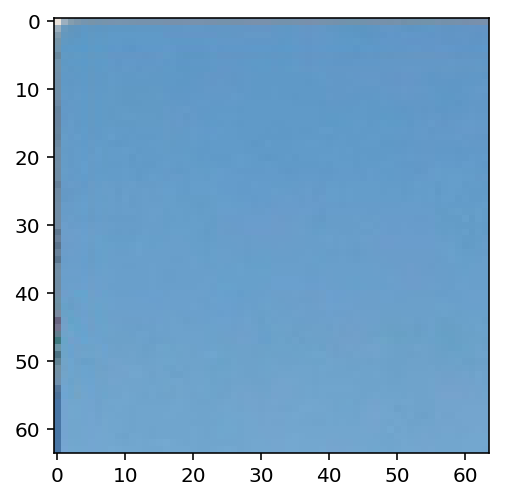

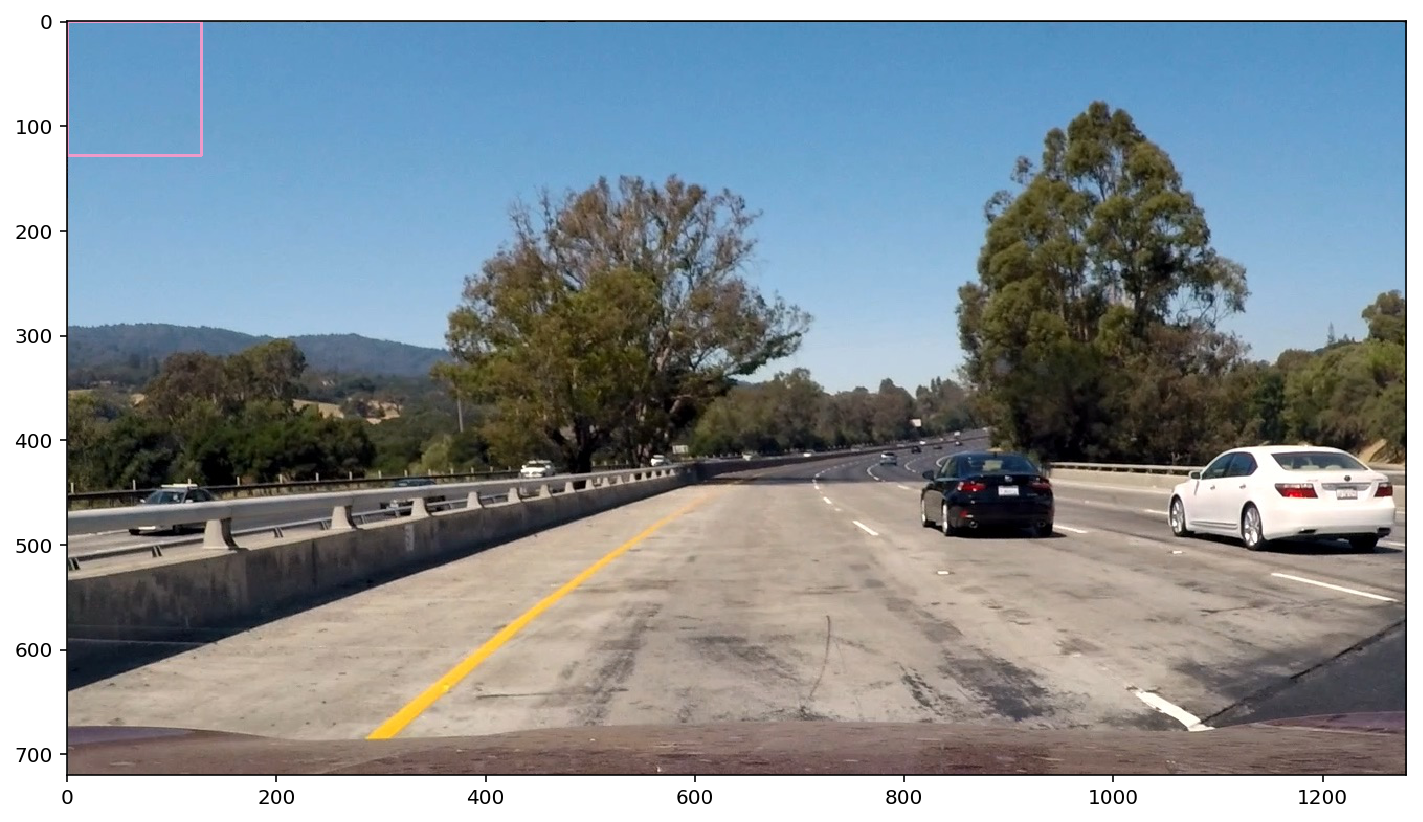

In [316]:
hog_sliding_window_test('test_images/test1.jpg',scale = 2)

In [228]:
from scipy.ndimage.measurements import label

def add_heat(heatmap,boxes):
    for box in boxes:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def get_labeled_boxes(labels):
    
    results = []
    
    image,count = labels
    
    for i in range(0,count):
        
        nonzero = (image == i + 1).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))

        results.append(bbox)

    return results

class Memory():
    def __init__(self,n):
        self._n = n
        self._maps = []
        
    def add_heatmap(self,heatmap):
        
        if len(self._maps) == 0:
            self._maps = [heatmap for i in range(self._n)]
        
        else:
            self._maps.insert(0,heatmap)
            self._maps.pop()

    
    def heatmap(self):
        return np.mean(self._maps, axis = 0)
    
def process_image(image,memory,n):
    boxes = get_matching_boxes(image)
  
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    add_heat(heatmap,boxes)
    memory.add_heatmap(heatmap)
    heatmap = memory.heatmap()
    heatmap = apply_threshold(heatmap,1.5)
    labels = label(heatmap)

    bboxes = get_labeled_boxes(labels)
 
    result = draw_boxes(image, boxes, thick=2)
    return result

def create_process_image():
    
    n = 10
    memory = Memory(n)
    
    return lambda img : process_image(img,memory,n)



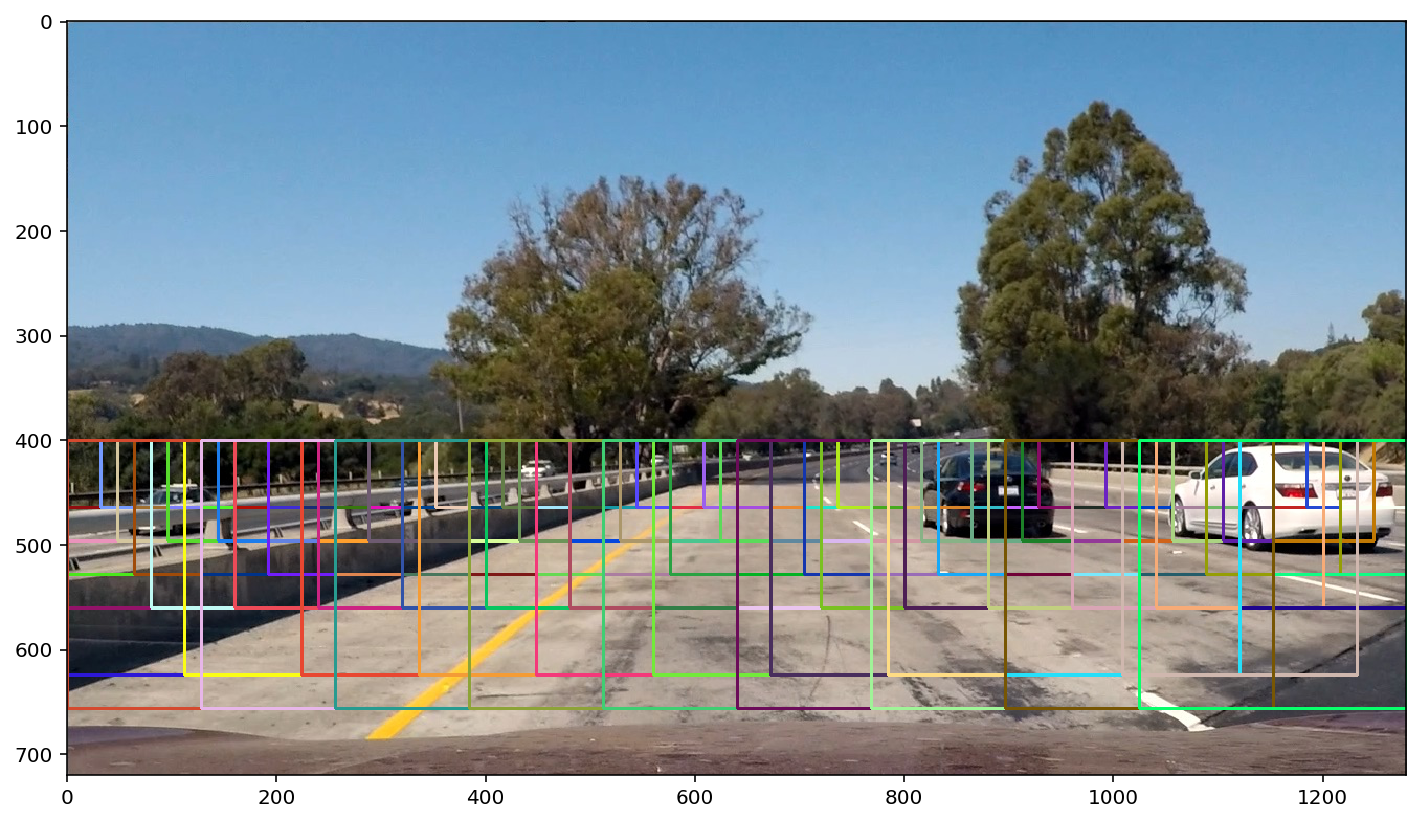

In [229]:
image = mpimg.imread('test_images/test1.jpg')

process = create_process_image()
result = process(image)


plt.figure(figsize=(12,12))
plt.imshow(result)

In [29]:
import imageio
imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [30]:
file = 'project_video.mp4'
white_output = 'output_videos/' + file

##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(file)

process = create_process_image()

white_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [10:06<00:00,  2.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 10min 6s
